
# Genetikus algoritmusok – **Rekombinációs (keresztezési) módszerek** (HU)

**Notebook:** A legfontosabb keresztezési módszerekről bináris, valós, permutációs és fa/szabály alapú kódolásban.


In [4]:

import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
from sympy import symbols

random.seed(123)
np.random.seed(123)
plt.style.use("seaborn-v0_8-muted")
np.set_printoptions(precision=4, suppress=True)



## 1) Miért van szükség rekombinációra az EA-ban?
- Információkeverés két szülő jó tulajdonságainak kombinálására.
- Feltárás + kihasználás egyensúlya, diverzitás fenntartása.



## 2) Bináris kódolású keresztezések: 1-pontos, 2-pontos, uniform (bónusz feladat)


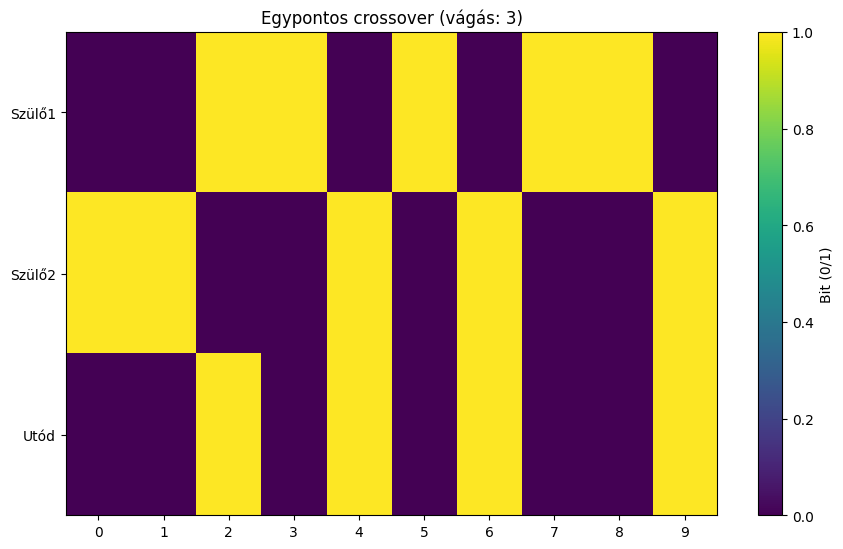

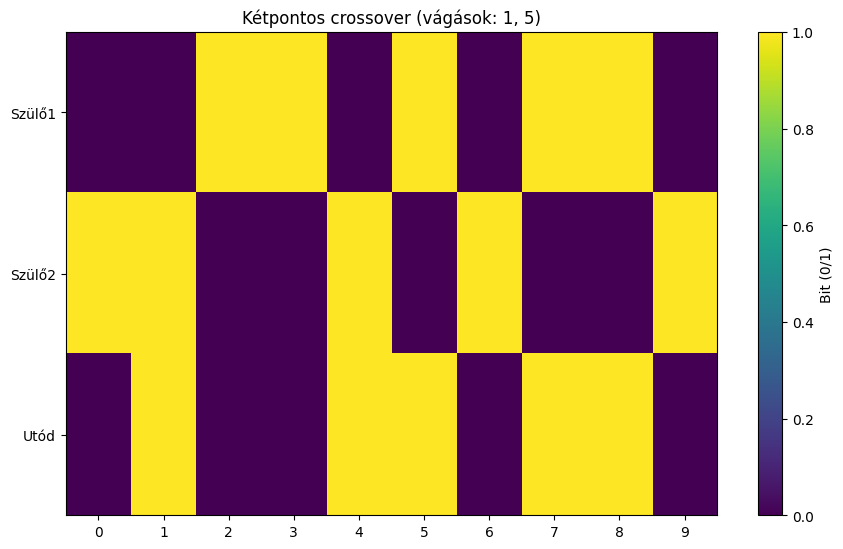

In [5]:

def plot_bitstrings(parents, child=None, title=""):
    arrs = [np.array(p) for p in parents]
    labels = [f"Szülő{i+1}" for i in range(len(parents))]
    if child is not None:
        arrs.append(np.array(child))
        labels.append("Utód")
    M = np.vstack(arrs)
    plt.figure(figsize=(min(12, 0.6*M.shape[1]+3), 1.2*M.shape[0]+2))
    plt.imshow(M, aspect='auto', interpolation='nearest')
    plt.colorbar(label="Bit (0/1)")
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(M.shape[1]), range(M.shape[1]))
    plt.title(title)
    plt.tight_layout()
    plt.show()

def one_point_crossover(a, b):
    if len(a) < 2: return a[:], b[:], 0
    point = np.random.randint(1, len(a))
    c1 = a[:point] + b[point:]
    c2 = b[:point] + a[point:]
    return c1, c2, point

def two_point_crossover(a, b):
    assert len(a) >= 3
    i, j = sorted(np.random.choice(range(1, len(a)), size=2, replace=False))
    c1 = a[:i] + b[i:j] + a[j:]
    c2 = b[:i] + a[i:j] + b[j:]
    return c1, c2, (i, j)



# Demo
p1 = [0,0,1,1,0,1,0,1,1,0]
p2 = [1,1,0,0,1,0,1,0,0,1]

c1, c2, pt = one_point_crossover(p1, p2)
plot_bitstrings([p1,p2], c1, title=f"Egypontos crossover (vágás: {pt})")

c1, c2, (i,j) = two_point_crossover(p1, p2)
plot_bitstrings([p1,p2], c1, title=f"Kétpontos crossover (vágások: {i}, {j})")




## 3) Permutációs keresztezések: PMX, OX, CX


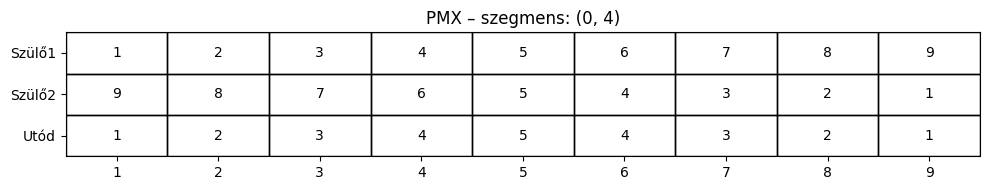

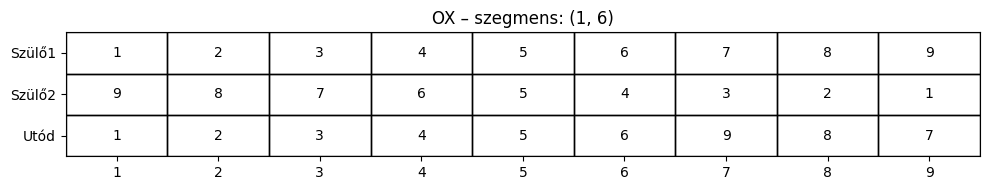

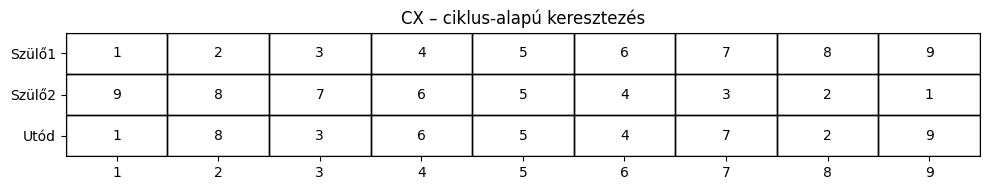

In [6]:

def pmx(p1, p2):
    n = len(p1)
    a, b = sorted(random.sample(range(n), 2))
    child = [None]*n
    child[a:b] = p1[a:b]
    mapping = {p2[i]: p1[i] for i in range(a,b)}
    for i in list(range(0,a)) + list(range(b,n)):
        candidate = p2[i]
        while candidate in mapping:
            candidate = mapping[candidate]
        child[i] = candidate
    return child, (a,b)

def ox(p1, p2):
    n = len(p1)
    a, b = sorted(random.sample(range(n), 2))
    child = [None]*n
    child[a:b] = p1[a:b]
    fill = [x for x in p2 if x not in child[a:b]]
    idxs = list(range(b, n)) + list(range(0, a))
    for i, v in zip(idxs, fill):
        child[i] = v
    return child, (a,b)

def cx(p1, p2):
    n = len(p1)
    child = [None]*n
    idx = 0
    take_from_p1 = True
    while None in child:
        if child[idx] is None:
            cyc = []
            x = p1[idx]
            while True:
                cyc.append(idx)
                y = p2[idx]
                idx = p1.index(y)
                if idx == cyc[0]:
                    break
            for k in cyc:
                child[k] = p1[k] if take_from_p1 else p2[k]
            take_from_p1 = not take_from_p1
        idx = (idx+1) % n
    return child

def plot_permutation(parent1, parent2, child, title):
    labels = ["Szülő1", "Szülő2", "Utód"]
    data = [parent1, parent2, child]
    plt.figure(figsize=(10, 2))
    for row, seq in enumerate(data):
        for col, v in enumerate(seq):
            plt.text(col+0.5, row+0.5, str(v), ha='center', va='center')
            plt.gca().add_patch(plt.Rectangle((col, row), 1, 1, fill=False))
    plt.xlim(0, len(parent1))
    plt.ylim(0, len(data))
    plt.yticks(np.arange(0.5, len(data)+0.5), labels)
    plt.xticks(np.arange(0.5, len(parent1)+0.5), range(1, len(parent1)+1))
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Demo
p1 = [1,2,3,4,5,6,7,8,9]
p2 = [9,8,7,6,5,4,3,2,1]

child_pmx, seg = pmx(p1, p2)
plot_permutation(p1, p2, child_pmx, title=f"PMX – szegmens: {seg}")

child_ox, seg = ox(p1, p2)
plot_permutation(p1, p2, child_ox, title=f"OX – szegmens: {seg}")

child_cx = cx(p1, p2)
plot_permutation(p1, p2, child_cx, title="CX – ciklus-alapú keresztezés")



## 4) Fa/szabály-alapú rekombinációk: (a) subtree, (b) edge, (c) szabályblokkok (Bónusz feladatok)



## 5) Kérdések – rövid, magyar válaszok

**Miért van szükség rekombinációra az EA-ban?**  
Kevert információ, új kombinációk, diverzitás, feltárás-kihasználás egyensúlya.

**Miben különbözik az egypontos és az uniform crossover?**  
Egypontos: blokkok/összefüggések jobban megmaradnak. Uniform: génszinten dönt → erősebb keverés, de töredezett szerkezet.

**Miért speciális a crossover permutációknál?**  
Az utódnak érvényes permutáció marad: minden elem pontosan egyszer. Speciális operátorok (PMX, OX, CX) biztosítják.



## 6) Összegző táblázat

| Típus | Módszer | Előny | Hátrány | Megjegyzés |
|---|---|---|---|---|
| Bináris | 1- és 2-pontos | Blokkok megőrzése | Kisebb keverés | Lokális szerkezet |
| Bináris | Uniform | Erős keverés | Szerkezet töredezhet | p szabályoz |
| Valós | Lineáris | Egyszerű | Szűk tartomány | α súly |
| Valós | BLX-α | Feltáró | Paraméterérzékeny | α tartomány-szélesítés |
| Valós | SBX | Bináris-analóg | η hangolás kell | Kis η → széles |
| Permutáció | PMX/OX/CX | Érvényesség | Bonyolultabb | Sorrend megőrzése |
| Fa | Subtree | Kifejező | Költséges | GP |
| Gráf | Edge | Topológia-keverés | Érvényesség | Unió/összevonás |
| Szabály | Blokkok | Moduláris csere | Kontextusfüggő | Szabálylisták |
